# Implementing Aspect Based Sentiment Analysis using Python

Link : https://medium.com/analytics-vidhya/aspect-based-sentiment-analysis-a-practical-approach-8f51029bbc4a
·


In [47]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [65]:
# Standard data manipulation and analysis libraries
import pandas as pd
import numpy as np


from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Natural Language Processing (NLP) libraries
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import stanfordnlp

# Text preprocessing and machine learning libraries
import matplotlib.pyplot as plt
import re
import stanza
import string
from tqdm import tqdm
from transformers import pipeline
from sklearn.preprocessing import Binarizer
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer

# Topic modeling and clustering libraries
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN

# Interpretability and explanation libraries
import shap

# Additional text processing libraries
import nltk.stem
from nltk.tokenize import word_tokenize, sent_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vitrac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/vitrac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [49]:
stanfordnlp.download('en')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
stanza.download('en') # This downloads the English models for the neural pipeline

Using the default treebank "en_ewt" for language "en".
Would you like to download the models for: en_ewt now? (Y/n)

Default download directory: /Users/vitrac/stanfordnlp_resources
Hit enter to continue or type an alternate directory.

Download location: /Users/vitrac/stanfordnlp_resources/en_ewt_models.zip


100%|██████████| 235M/235M [00:41<00:00, 5.62MB/s] 



Download complete.  Models saved to: /Users/vitrac/stanfordnlp_resources/en_ewt_models.zip
Extracting models file for: en_ewt
Cleaning up...Done.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vitrac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/vitrac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/vitrac/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
2023-10-17 07:56:38 INFO: Downloading default packages for language: en (English) ...
2023-10-17 07:56:39 INFO: File exists: /Users/vitrac/stanza_resources/en/default.zip
2023-10-17 07:56:42 INFO: Finished downloading models and saved to /Users/vitrac/stanza_resources.


In [178]:
# Adapt to individual path
file_path = 'data/raw_data_healthcare.csv'
df = pd.read_csv(file_path)

nltk.download('stopwords')

def clean_comment(row):
    # Lower comments
    comment = row['comment'].lower() 
    # Delete ponctuation
    comment = ''.join([char for char in comment if char not in string.punctuation]) 
    words = comment.split() 
    # Delete stop words (english)
    stop_words = set(stopwords.words('english')) 
    words = [word for word in words if word not in stop_words]
    cleaned_comment = ' '.join(words) 
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return cleaned_comment

def process_dataframe(df):

    df = df.copy()

    if 'comment' not in df.columns:
        raise ValueError("DataFrame must contain a column named 'comment'")
    punctuations = string.punctuation
    df['medication'] = df['medication'].str.replace(f"[{re.escape(punctuations)}]", "", regex=True)
    df['medication'] = df['medication'].str.lower()

    df['cleaned_comment'] = df.apply(clean_comment, axis=1)

    # Extracting treatment name, treatment code, and disease name
    pattern = r'(?P<treatment_name>.+?) (?P<treatment_code>.+?) for (?P<disease_name>.+?)( Maintenance)?$'
    extracted_data = df['medication'].str.extract(pattern)
    df['Treatment name'] = extracted_data['treatment_name']
    df['Treatment code'] = extracted_data['treatment_code']
    df['Disease'] = extracted_data['disease_name']

    # Replace disease, treatment code and treatment name per generic formulas
    replacement_dict = {
        # Disease replacements 
        'crohns disease': 'disease',
        'rheumatoid arthritis': 'disease',
        'ulcerative colitis': 'disease',
        'crohns disease maintenance': 'disease',
        'psoriatic arthritis': 'disease',
        'ankylosing spondylitis': 'disease',
        'ulcerative colitis maintenance': 'disease',
        'crohn': 'disease',
        "chron's": 'disease',
        'crohns': 'disease',
        # Treatment code replacements
        'infliximab': 'treatment_code',
        'adalimumab': 'treatment_code',
        'certolizumab': 'treatment_code',
        'golimumab': 'treatment_code',
        'aria golimumab': 'treatment_code',
        'vedolizumab': 'treatment_code',
        'ustekinumab': 'treatment_code',
        'natalizumab': 'treatment_code',
        # Treatment name replacements
        'inflectra': 'treatment_name',
        'remicade': 'treatment_name',
        'renflexis': 'treatment_name',
        'humira': 'treatment_name',
        'cimzia': 'treatment_name',
        'simponi': 'treatment_name',
        'entyvio': 'treatment_name',
        'stelara': 'treatment_name',
        'tysabri': 'treatment_name'
    }
    
    # Appliquez les remplacements dans la colonne 'cleaned_comment' en utilisant le dictionnaire
    df['cleaned_comment'] = df['cleaned_comment'].replace(replacement_dict, regex=True)

    return df

# Preprocess the dataframe
df = process_dataframe(df)

# Display the dataframe
df.head()


,text_index,medication,rate,comment,cleaned_comment,Treatment name,Treatment code,Disease
0,0,inflectra infliximab for crohns disease,1.0,Insurance forced me to switch to inflectra due...,insurance forced switch treatment_name due che...,inflectra,infliximab,crohns disease
1,1,remicade infliximab for rheumatoid arthritis,NaN,My wife had RA from when she was a child. She ...,wife ra child used normal meds till treatment_...,remicade,infliximab,rheumatoid arthritis
2,2,remicade infliximab for ulcerative colitis,1.0,This medication Remicade made me in constant p...,medication treatment_name made constant pain s...,remicade,infliximab,ulcerative colitis
3,3,inflectra infliximab for crohns disease,1.0,"I have Fistulizing Crohn's, dx'd 6 yrs ago @ 3...",fistulizing diseases dxd 6 yrs ago 36yo 11 sur...,inflectra,infliximab,crohns disease
4,4,remicade infliximab for ulcerative colitis,10.0,Remicade literally gave me my life back 9 yrs ...,treatment_name literally gave life back 9 yrs ...,remicade,infliximab,ulcerative colitis


In [169]:
# Add a sentiment analysis to classify comments 
def add_sentiment_analysis(df):
    df = df.copy()
    sentiment_analyzer = pipeline("sentiment-analysis")
    sentiment_results = sentiment_analyzer(df["cleaned_comment"].tolist())
    # Extract sentiment labels and scores
    sentiment_labels = [entry['label'] for entry in sentiment_results]
    sentiment_scores = [entry['score'] for entry in sentiment_results]
    # Add the sentiment label and score as new columns to the DataFrame
    df['sentiment'] = sentiment_labels
    df['sentiment_score'] = sentiment_scores
    return df
df = add_sentiment_analysis(df)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


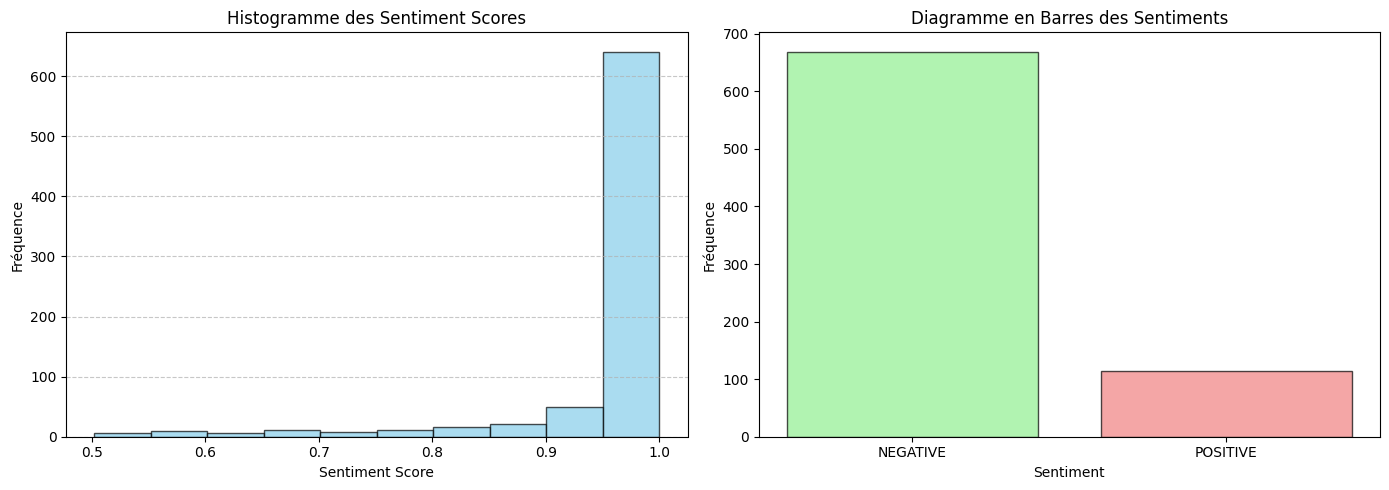

In [63]:
import matplotlib.pyplot as plt

# Créer une figure avec deux sous-graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Premier sous-graphique : Histogramme des sentiment_score
axes[0].hist(df['sentiment_score'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Histogramme des Sentiment Scores')
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Fréquence')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Deuxième sous-graphique : Diagramme en barres des sentiments
sentiment_counts = df['sentiment'].value_counts()
axes[1].bar(sentiment_counts.index, sentiment_counts.values, color=['lightgreen', 'lightcoral'], edgecolor='black', alpha=0.7)
axes[1].set_title('Diagramme en Barres des Sentiments')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Fréquence')

plt.tight_layout()
plt.show()


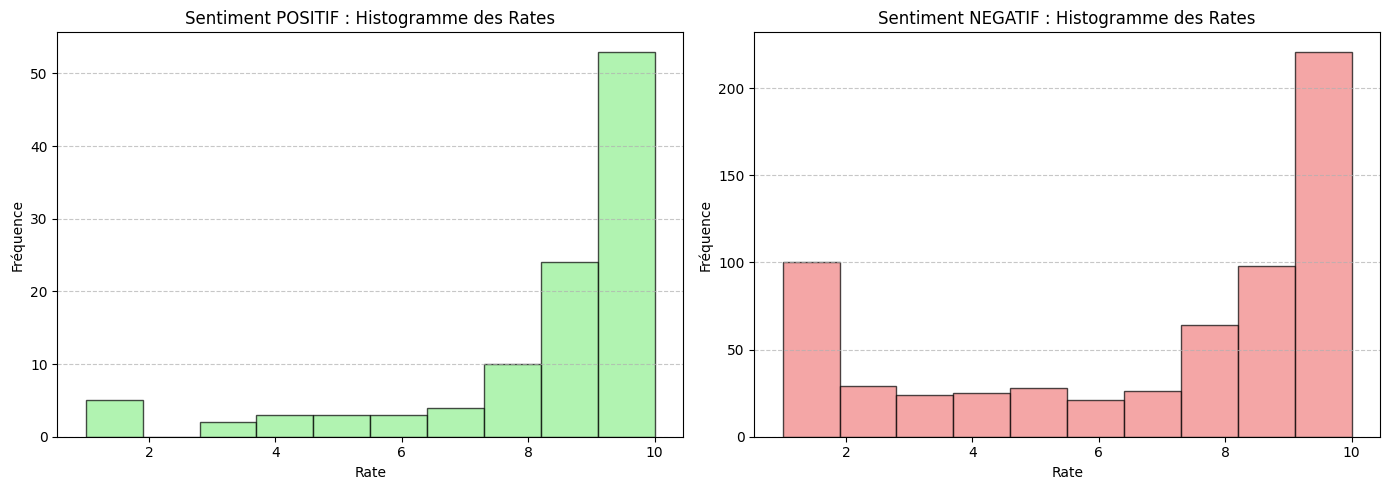

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sous-graphique pour sentiment POSITIF
positive_df = df[df['sentiment'] == 'POSITIVE']
axes[0].hist(positive_df['rate'], bins=10, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0].set_title('Sentiment POSITIF : Histogramme des Rates')
axes[0].set_xlabel('Rate')
axes[0].set_ylabel('Fréquence')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Sous-graphique pour sentiment NEGATIF
negative_df = df[df['sentiment'] == 'NEGATIVE']
axes[1].hist(negative_df['rate'], bins=10, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].set_title('Sentiment NEGATIF : Histogramme des Rates')
axes[1].set_xlabel('Rate')
axes[1].set_ylabel('Fréquence')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### 2 - Implementing Preprocessing for Aspect Based Sentiment Analysis 

In [67]:
def create_flagged_comment(taggedList):
    # Pour l'étape 3 - get taggedList
    newwordList = []
    flag = 0
    for i in range(0,len(taggedList)-1):
        if(taggedList[i][1]=="NN" and taggedList[i+1][1]=="NN"):
            newwordList.append(taggedList[i][0]+taggedList[i+1][0])
            flag=1
        else:
            if(flag==1):
                flag=0
                continue
            newwordList.append(taggedList[i][0])
            if(i==len(taggedList)-2):
                newwordList.append(taggedList[i+1][0])
    finaltxt = ' '.join(word for word in newwordList)
    return finaltxt

def create_flagged_comment_get_newwordList(taggedList):
    # Pour l'étape 3 - get newwordList
    newwordList = []
    flag = 0
    for i in range(0,len(taggedList)-1):
        if(taggedList[i][1]=="NN" and taggedList[i+1][1]=="NN"):
            newwordList.append(taggedList[i][0]+taggedList[i+1][0])
            flag=1
        else:
            if(flag==1):
                flag=0
                continue
            newwordList.append(taggedList[i][0])
            if(i==len(taggedList)-2):
                newwordList.append(taggedList[i+1][0])
    finaltxt = ' '.join(word for word in newwordList)
    return newwordList

def tokenize_and_pos_tag(comment):
    # Pour l'étape 4 - supprime les stopwords 
    stop_words = set(stopwords.words('english'))
    new_txt_list = nltk.word_tokenize(comment)
    wordsList = [w for w in new_txt_list if not w in stop_words]
    taggedList = nltk.pos_tag(wordsList)
    return taggedList

nlp = stanza.Pipeline('en') # This sets up a default neural pipeline in English

def extract_dependencies(row):
    # Fonction pour extraire les dépendances syntaxiques
    # Pour l'étape 5
    sentence = row['flagged_comment']
    newwordList = row['newwordList']
    doc = nlp(sentence)
    dep_node = []
    for dep_edge in doc.sentences[0].dependencies:
        dep_node.append([dep_edge[2].text, dep_edge[0].id, dep_edge[1]])
    for i in range(0, len(dep_node)):
        if int(dep_node[i][1]) != 0:
            source_index = int(dep_node[i][1]) - 1
            if 0 <= source_index < len(newwordList):
                dep_node[i][1] = newwordList[source_index]
            else:
                dep_node[i][1] = 'Out of range'
    return dep_node

def extract_features(df):
    df = df.copy()
    # Etape 5
    featureList = []  # To store features for each row
    categoriesList = []  # To store categories for each row
    
    for tagged_comment in df['tagged_comment']:
        features = []
        categories = []
        
        for word, pos in tagged_comment:
            if pos in ['JJ', 'NN', 'JJR', 'NNS', 'RB']:
                features.append([word, pos])
                categories.append(pos)
        
        featureList.append(features)
        categoriesList.append(categories)
    
    df['featureList'] = featureList
    df['categoriesList'] = categoriesList
    return df


2023-10-17 08:12:54 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-10-17 08:12:56 INFO: Loading these models for language: en (English):
| Processor    | Package             |
--------------------------------------
| tokenize     | combined            |
| pos          | combined_charlm     |
| lemma        | combined_nocharlm   |
| constituency | ptb3-revised_charlm |
| depparse     | combined_charlm     |
| sentiment    | sstplus             |
| ner          | ontonotes_charlm    |

2023-10-17 08:12:56 INFO: Using device: cpu
2023-10-17 08:12:56 INFO: Loading: tokenize
2023-10-17 08:12:56 INFO: Loading: pos
2023-10-17 08:12:56 INFO: Loading: lemma
2023-10-17 08:12:56 INFO: Loading: constituency
2023-10-17 08:12:57 INFO: Loading: depparse
2023-10-17 08:12:57 INFO: Loading: sentiment
2023-10-17 08:12:57 INFO: Loading: ner
2023-10-17 08:1

In [164]:
def find_nominal_groups_indices(tag_list):
    nominal_groups_indices = []  
    current_group = []  
    for i, tag in enumerate(tag_list):
        if tag in ['DT', 'JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS']:
            current_group.append(i)
        else:
            if current_group:
                nominal_groups_indices.append(current_group)
                current_group = []  
    if current_group:
        nominal_groups_indices.append(current_group)
    nominal_groups_indices = [group for group in nominal_groups_indices if len(group) > 1]
    return nominal_groups_indices

tag_list = ['NN', 'VBD', 'PRP', 'TO', 'VB', 'TO', 'VB', 'JJ', 'TO', 'VBG', 'JJR', 'IN', 'NNP', 'IN', 'PRP$', 'NNP', 'POS', '.', 'PRP', 'VBD', 'RB', 'VB', 'DT', 'NN', ',', 'CC', 'NN', 'MD', 'RB', 'VB', 'TO', 'NNP', 'NNS', '.', 'IN', 'IN', 'NNP', 'PRP', 'RB', 'VBD', 'VBN', 'JJ', 'CD', 'NNS', 'DT', 'NN', 'IN', 'PRP$', 'NN', ',', 'CC', 'DT', 'JJ', 'NNS', 'CC', 'NN', 'NNS', '.', 'CC', 'IN', 'RB', 'CD', 'NNS', 'IN', 'NN', 'PRP', 'VBP', 'JJ', 'JJ', 'JJ', 'NNS', 'RB', 'IN', 'JJ', 'NN', ',', 'RB', 'RB', 'IN', 'NN', 'NNS', 'IN', 'JJS', 'RB', 'DT', 'NN', '.', 'IN', 'NN', 'TO', 'NNP', 'RB', 'VBG', 'NN', 'NNS', ',', 'NN', ',', 'CC', 'NNS', ':', 'NNP', 'VBZ', 'VBN', 'JJR', 'NNS', 'IN', 'PRP', 'VBD', 'RB', 'VB', 'RB', ':', 'NNP', 'NN', 'NNP', 'NNP', 'NNP', 'NN', ':', 'NNS', ',', 'NNS', ',', 'NNS', '.', 'NN', 'NNP', 'NNP', 'NNP', 'NNP', 'NN', 'NN', 'IN', 'PRP$', 'NNS', ',', 'WRB', 'PRP', 'MD', 'RB', 'VB', 'PRP$', 'NN', ':', 'PRP', 'VBZ', 'RB', 'VBN', '.', 'PRP', 'VBP', 'IN', 'PRP$', 'JJ', 'CD', 'POS', 'IN', 'DT', 'NN', 'TO', 'VB', 'TO', 'VB', 'RP', 'IN', ',', 'RB', 'RB', 'IN', 'NN', 'TO', 'VB', ',', 'CC', 'DT', 'VBZ', 'RB', 'JJ', 'TO', 'PRP', 'CC', 'PRP$', 'NN', '.']
nominal_groups_indices = find_nominal_groups_indices(tag_list)
print(nominal_groups_indices)


[[22, 23], [31, 32], [43, 44, 45], [51, 52, 53], [55, 56], [67, 68, 69, 70], [73, 74], [79, 80], [84, 85], [93, 94], [104, 105], [113, 114, 115, 116, 117, 118], [126, 127, 128, 129, 130, 131, 132], [158, 159]]


In [166]:
comment1 = df['comment'].iloc[0]

nltk.download('punkt')

def find_nominal_groups_indices(tag_list):
    nominal_groups_indices = []  
    current_group = []  
    for i, tag in enumerate(tag_list):
        if tag in ['DT', 'JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS']:
            current_group.append(i)
        else:
            if current_group:
                nominal_groups_indices.append(current_group)
                current_group = []  
    if current_group:
        nominal_groups_indices.append(current_group)
    nominal_groups_indices = [group for group in nominal_groups_indices if len(group) > 1]
    return nominal_groups_indices

word_tokens = [nltk.word_tokenize(comment1)]
new_word_tokens = []
new_tagged_word = []
for word in word_tokens:
    tagged_words = nltk.pos_tag(word)
    tags_list = [tag for word, tag in tagged_words]
    nominal_group_indices = find_nominal_groups_indices(tag_list)
    for i in range (len(tags_list)):
        for k in range (len(nominal_group_indices)):
    print('tag: ', tags_list)

    
    tree = chunk_parser.parse(tagged_tokens)
    for subtree in tree.subtrees():
        if subtree.label() == 'NP':
            noun_phrase = ' '.join([word for word, tag in subtree.leaves()])
            noun_phrases.append(noun_phrase)

# Afficher les groupes nominaux
for phrase in noun_phrases:
    print(phrase)


Résultat de la phrase avec groupes nominaux remplacés par 'GN':
a say Dr. recommendations days a month no other issues side effects multiple daily loose stools healthy diet bloody stools a day flare ups more issues Kidney pain Rib Pain Joint pain Nausea Headaches Severe Fatigue Charlie horse cramping a toddler Insurance forced me to switch to inflectra due to being cheaper for THEM for my Crohn 's . I did not have , and insurance wo n't listen to . While on Treatment I only had flare ups 3 during my period , but or . Yet after only 2 infusions on Treatment I have regardless of , as well as at least once . In addition to Treatment not preventing , inflammation , and symptoms ; Treatment has incurred that I did n't have previously : : shoulders , wrists , ankles . in my hands , where I ca n't move my thumb ; it 's completely contracted . I 'm in my early 40 's with to try to keep up with , as well as career to maintain , and this is n't fair to me or my family .


[nltk_data] Downloading package punkt to /Users/vitrac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [68]:
def preprocessing_for_ABSA(df):

    stop_words = set(stopwords.words('english')) 
    
    # Étape 1: Tokeniser les commentaires en phrases
    df['tokenized_comments'] = df['comment'].str.lower()
    df['tokenized_comments'] = df['tokenized_comments'].str.replace(f"[{re.escape(string.punctuation)}]", "", regex=True)
    df['tokenized_comments'] = df['tokenized_comments'].apply(nltk.sent_tokenize)
    print('Step 1 : Done')

    # Étape 2: Tokenize each sentence into words, et tag each element - 
    df['tagged_comment'] = df['tokenized_comments'].apply(lambda sentences: [nltk.pos_tag(nltk.word_tokenize(sentence)) for sentence in sentences])
    df['tagged_comment'] = df['tagged_comment'].apply(lambda sentences: sentences[0])
    print('Step 2 : Done')

    # Étape 3: Appliquer la fonction create_flagged_comment à chaque ligne
    df['flagged_comment'] = df['tagged_comment'].apply(create_flagged_comment)
    df['newwordList'] = df['tagged_comment'].apply(create_flagged_comment_get_newwordList)
    print('Step 3 : Done')

    # Etape 4 : Appliquer la fonction pour créer la nouvelle colonne 'new_sentence'
    df['new_sentence'] = df['flagged_comment'].apply(tokenize_and_pos_tag)
    print('Step 4 : Done')

    # Etape 5 : Appliquer la fonction pour créer la nouvelle colonne 'dep_node'
    tqdm.pandas(desc="Extracting dependencies")
    df['dep_node'] = df.progress_apply(extract_dependencies, axis=1)
    print('Step 5 : Done')

    # Etape 6 : Extracting the features
    # We select only those sublists from the <dep_node> that could probably contain the features.
    df = extract_features(df)
    print('Step 6 : Done')

    return df

In [119]:
# Preprocess the positive dataframe
df_positive = df[df['sentiment']=='POSITIVE'].copy()
df_positive_preprocessed = preprocessing_for_ABSA(df_positive)
df_positive_preprocessed.head()

Step 1 : Done
Step 2 : Done
Step 3 : Done
Step 4 : Done


Extracting dependencies: 100%|██████████| 115/115 [04:03<00:00,  2.12s/it]

Step 5 : Done
Step 6 : Done


,text_index,medication,rate,comment,cleaned_comment,Treatment name,Treatment code,Disease,sentiment,sentiment_score,tokenized_comments,tagged_comment,flagged_comment,newwordList,new_sentence,dep_node,featureList,categoriesList
20,20,Remicade infliximab for Rheumatoid Arthritis,10.0,I was diagnosed with RA about 12 years ago. St...,diagnosed ra 12 years ago started methotrexate...,Remicade,infliximab,Rheumatoid Arthritis,POSITIVE,0.891146,[i was diagnosed with ra about 12 years ago st...,"[(i, NN), (was, VBD), (diagnosed, VBN), (with,...",i was diagnosed with ra about 12 years ago sta...,"[i, was, diagnosed, with, ra, about, 12, years...","[(diagnosed, VBN), (ra, JJ), (12, CD), (years,...","[[i, diagnosed, nsubj:pass], [was, diagnosed, ...","[[i, NN], [ra, NN], [years, NNS], [ago, RB], [...","[NN, NN, NNS, RB, NN, JJR, JJ, JJ, NNS, NN, NN..."
22,22,Remicade infliximab for Ulcerative Colitis,10.0,Treatment has been a miracle for me. Last year...,remicade miracle last year time totally desper...,Remicade,infliximab,Ulcerative Colitis,POSITIVE,0.977598,[treatment has been a miracle for me last year...,"[(treatment, NN), (has, VBZ), (been, VBN), (a,...",treatment has been a miracle for me last year ...,"[treatment, has, been, a, miracle, for, me, la...","[(treatment, NN), (miracle, NN), (last, JJ), (...","[[treatment, miracle, nsubj], [has, miracle, a...","[[treatment, NN], [miracle, NN], [last, JJ], [...","[NN, NN, JJ, NN, NN, NN, RB, JJ, NN, NN, NN, N..."
27,27,Remicade infliximab for Crohns Disease Mainten...,7.0,"Right after my daughters 13 yr. birthday, she ...",right daughters 13 yr birthday severe bleeding...,Remicade,infliximab,Crohns Disease,POSITIVE,0.802743,[right after my daughters 13 yr birthday she h...,"[(right, RB), (after, IN), (my, PRP$), (daught...",right after my daughters 13 yrbirthday she had...,"[right, after, my, daughters, 13, yrbirthday, ...","[(right, JJ), (daughters, NNS), (13, CD), (yrb...","[[right, daughters, advmod], [after, daughters...","[[right, RB], [daughters, NNS], [yr, NN], [bir...","[RB, NNS, NN, NN, JJ, NN, JJ, NN, NN, NN, NN, ..."
31,31,Remicade infliximab for Ulcerative Colitis,8.0,I have only been living with this UC for about...,living uc 5 months couldn’t find anything help...,Remicade,infliximab,Ulcerative Colitis,POSITIVE,0.786062,[i have only been living with this uc for abou...,"[(i, NN), (have, VBP), (only, RB), (been, VBN)...",i have only been living with this uc for about...,"[i, have, only, been, living, with, this, uc, ...","[(living, VBG), (uc, JJ), (5, CD), (months, NN...","[[i, living, nsubj], [have, living, aux], [onl...","[[i, NN], [only, RB], [uc, NN], [months, NNS],...","[NN, RB, NN, NNS, NN, NN, NN, NN, NN, JJ, NN, ..."
32,32,Remicade infliximab for Psoriatic Arthritis,9.0,I went in yesterday morning at 9am to receive ...,went yesterday morning 9am receive first infus...,Remicade,infliximab,Psoriatic Arthritis,POSITIVE,0.975392,[i went in yesterday morning at 9am to receive...,"[(i, JJ), (went, VBD), (in, IN), (yesterday, N...",i went in yesterdaymorning at 9am to receive m...,"[i, went, in, yesterdaymorning, at, 9am, to, r...","[(went, VBD), (yesterdaymorning, VBG), (9am, C...","[[i, went, nsubj], [went, 0, root], [in, yeste...","[[i, JJ], [yesterday, NN], [morning, NN], [fir...","[JJ, NN, NN, JJ, NN, NN, NN, NN, NNS, NN, RB, ..."


In [71]:
# Preprocess the negative dataframe
df_negative = df[df['sentiment']=='NEGATIVE'].copy()
df_negative_preprocessed = preprocessing_for_ABSA(df_negative)
df_negative_preprocessed.head()

Step 1 : Done
Step 2 : Done
Step 3 : Done
Step 4 : Done


Extracting dependencies: 100%|██████████| 50/50 [02:24<00:00,  2.88s/it]

Step 5 : Done
Step 6 : Done


,text_index,medication,rate,comment,cleaned_comment,Treatment name,Treatment code,Disease,sentiment,sentiment_score,tokenized_comments,tagged_comment,flagged_comment,newwordList,new_sentence,dep_node,featureList,categoriesList
0,0,Inflectra infliximab for Crohns Disease,1.0,Insurance forced me to switch to inflectra due...,insurance forced switch inflectra due cheaper ...,Inflectra,infliximab,Crohns Disease,NEGATIVE,0.965539,[insurance forced me to switch to inflectra du...,"[(insurance, NN), (forced, VBD), (me, PRP), (t...",insurance forced me to switch to inflectra due...,"[insurance, forced, me, to, switch, to, inflec...","[(insurance, NN), (forced, VBD), (switch, NN),...","[[insurance, forced, nsubj], [forced, 0, root]...","[[insurance, NN], [due, JJ], [cheaper, JJR], [...","[NN, JJ, JJR, NN, NN, RB, NN, NN, NN, NNS, NN,..."
1,1,Remicade infliximab for Rheumatoid Arthritis,NaN,My wife had RA from when she was a child. She ...,wife ra child used normal meds till remicade j...,Remicade,infliximab,Rheumatoid Arthritis,NEGATIVE,0.994177,[my wife had ra from when she was a child she ...,"[(my, PRP$), (wife, NN), (had, VBD), (ra, VBN)...",my wife had ra from when she was a child she h...,"[my, wife, had, ra, from, when, she, was, a, c...","[(wife, NN), (ra, NN), (child, NN), (used, VBN...","[[my, wife, nmod:poss], [wife, ra, nsubj], [ha...","[[wife, NN], [child, NN], [normal, JJ], [meds,...","[NN, NN, JJ, NNS, NN, NN, NN, JJ, JJ, NN, NN, ..."
2,2,Remicade infliximab for Ulcerative Colitis,1.0,This medication Treatment made me in constant ...,medication remicade made constant pain slept t...,Remicade,infliximab,Ulcerative Colitis,NEGATIVE,0.995771,[this medication treatment made me in constant...,"[(this, DT), (medication, NN), (treatment, NN)...",this medicationtreatment made me in constant p...,"[this, medicationtreatment, made, me, in, cons...","[(medicationtreatment, NN), (made, VBD), (cons...","[[this, medicationtreatment, det], [medication...","[[medication, NN], [treatment, NN], [constant,...","[NN, NN, JJ, NN, NN, NNS, NNS, NN, NN, RB, JJ,..."
3,3,Inflectra infliximab for Crohns Disease,1.0,"I have Fistulizing Crohn's, dx'd 6 yrs ago @ 3...",fistulizing crohns dxd 6 yrs ago 36yo 11 surge...,Inflectra,infliximab,Crohns Disease,NEGATIVE,0.996202,[i have fistulizing crohns dxd 6 yrs ago 36yo...,"[(i, NNS), (have, VBP), (fistulizing, VBG), (c...",i have fistulizing crohnsdxd 6 yrs ago 36yo 11...,"[i, have, fistulizing, crohnsdxd, 6, yrs, ago,...","[(fistulizing, VBG), (crohnsdxd, NN), (6, CD),...","[[i, have, nsubj], [have, 0, root], [fistulizi...","[[i, NNS], [crohns, NN], [dxd, NN], [yrs, NN],...","[NNS, NN, NN, NN, RB, NNS, RB, JJ, NNS, NNS, N..."
4,4,Remicade infliximab for Ulcerative Colitis,10.0,Treatment literally gave me my life back 9 yrs...,remicade literally gave life back 9 yrs ago il...,Remicade,infliximab,Ulcerative Colitis,NEGATIVE,0.997025,[treatment literally gave me my life back 9 yr...,"[(treatment, NN), (literally, RB), (gave, VBD)...",treatment literally gave me my life back 9 yrs...,"[treatment, literally, gave, me, my, life, bac...","[(treatment, NN), (literally, RB), (gave, VBD)...","[[treatment, gave, nsubj], [literally, gave, a...","[[treatment, NN], [literally, RB], [life, NN],...","[NN, RB, NN, RB, NN, NN, RB, JJ, NNS, NNS, NNS..."


In [106]:
from collections import Counter

def extract_final_clusters(df):
    
    def create_feature_clusters(df):
        feature_clusters = []
        full_feature_list = []

        for index, row in df.iterrows():
            dep_node = row['dep_node']
            features = row['featureList']
            full_feature_list.append(features)
            for feature, pos in features:
                feature_cluster = []
                for j in dep_node:
                    if (j[0] == feature or j[1] == feature) and (j[2] in ["nsubj", "acl:relcl", "obj", "dobj", "agent", "advmod", "amod", "neg", "prep_of", "acomp", "xcomp", "compound"]):
                        if j[0] == feature:
                            feature_cluster.append(j[1])
                        else:
                            feature_cluster.append(j[0])
                if feature_cluster:
                    feature_clusters.append([feature, feature_cluster])
        # Applatir la liste full_feature_list
        flattened_feature_list = [item for sublist in full_feature_list for item in sublist]
        return feature_clusters, flattened_feature_list

    feature_clusters, full_feature_list = create_feature_clusters(df)

    finalcluster = []
    dic = {}
    for i in full_feature_list:
        dic[i[0]] = i[1]
    for i in feature_clusters:
        if dic[i[0]] == "NN":
            finalcluster.append(i)
    finalcluster = [item for item in finalcluster if item[0] not in ['i', 'say', 'wife', 'child', 'yrs', 'year', 't']]
    finalcluster = [item for item in finalcluster if len(item[1]) < 4]

    return finalcluster

def extract_sentiments(df_preprocessed):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Final cluster for positive sentiments
    finalcluster = extract_final_clusters(df_preprocessed)
    all_sentiments = [sentiment[0] for sentiment in finalcluster]
    sentiment_counts = Counter(all_sentiments)
    sorted_sentiments = sentiment_counts.most_common()
    sorted_sentiments = [[sentiment, count] for sentiment, count in sorted_sentiments]

    for i in range(len(sorted_sentiments)):
        sentiment = sorted_sentiments[i][0]
        mots_associes = []
        for j in range(len(finalcluster)):
            if sentiment == finalcluster[j][0]:
                mots_associes.append(finalcluster[j][1])
        mots_associes = [item for sublist in mots_associes for item in sublist]
        mots_associes_lemmatized = [lemmatizer.lemmatize(word, 'v') for word in mots_associes]
        mots_associes_lemmatized = [word for word in mots_associes_lemmatized if word not in stop_words]
        mots_associes_lemmatized = list(set(mots_associes_lemmatized))
        mots_associes_lemmatized = [word[:-1] if word.endswith('i') else word for word in mots_associes_lemmatized]
        sorted_sentiments[i].append(mots_associes_lemmatized)

    return sorted_sentiments


In [165]:
positive_sorted_sentiments = extract_sentiments(df_positive_preprocessed)
negative_sorted_sentiments = extract_sentiments(df_negative_preprocessed)

print('Positive comments, top 15 sentiments')
for i in range (15): 
    print(positive_sorted_sentiments[i])


Positive comments, top 15 sentiments
['treatment', 118, ['son', 'shots', 'swim', 'blessing', 'use', 'pen', 'help', 'wonderful', 'inventors', 'cover', 'medication', 'refuse', 'embrel', 'work', 'save', 'infusions', 'become', 'take', 'give', 'receive', 'start', 'topicals', 'go', 'lifesaver', 'fistulas', 'miraculous', 'crohns', 'transfusions', 'load', 'injections', 'lower', 'xeljanz', 'miracle', 'unstable', 'puva', 'decision', 'amaze', 'try', 'failure', 'prescribe', 'stop', 'female']]
['side', 31, ['effect']]
['life', 25, ['normal', 'change', 'turn', 'save', 'different', 'lead', 'give', 'bearable', 'strongly', 'begin', 'enjoy', 'get']]
['pain', 24, ['normal', 'terrible', 'omg', 'severe', 'happy', 'get', 'flare', 'much', 'start', 'swell', 'worsen', 'free', 'symptoms', 'experience', 'joint', 'way', 'abdominal', 'constant', 'debilitate', 'ibd', 'stop']]
['psoriasis', 18, ['contract', 'change', 'clear', 'scalp', 'come', 'notice', 'severe', 'go', 'maybe', 'get', 'plaque']]
['infusion', 16, ['su

In [117]:
print('Negative comments, top 15 sentiments')
for i in range (15): 
    print(negative_sorted_sentiments[i])

Negative comments, top 15 sentiments
['treatment', 69, ['age', 'mean', 'use', 'help', 'nervous', 'suggest', 'medicine', 'refuse', 'get', 'work', 'save', 'first', 'infusions', 'give', 'take', 'come', 'treatments', 'start', 'seem', 'change', 'symptoms', 'attack', 'hat', 'stop', 'life', 'love', 'incur']]
['side', 16, ['opposite', 'effect', 'effectsreactions', 'liver', 'except']]
['pain', 15, ['pills', 'shoulder', 'chest', '4th', 'hip', 'meds', 'swell', 'everywhere', 'almost', 'major', 'flareup', 'go', 'body', 'miracle', 'joint', 'get', 'ribpain']]
['doctor', 15, ['see', 'introduce', 'make', 'put', 'say', 'question', 'prove', 'love', 'treatment']]
['life', 15, ['normal', 'everyday', 'back', 'save', 'sleep', 'give', 'owe', 'treatment']]
['insurance', 10, ['lose', 'force', 'pay', 'let', 'pick', 'mandatory']]
['flare', 10, ['hospitalize', 'take', 'headaches', 'major', 'uc', 'get']]
['disease', 10, ['crohns', 'gallop', 'become', 'kidney', 'acquire', 'get']]
['infusion', 10, ['extend', 'first',

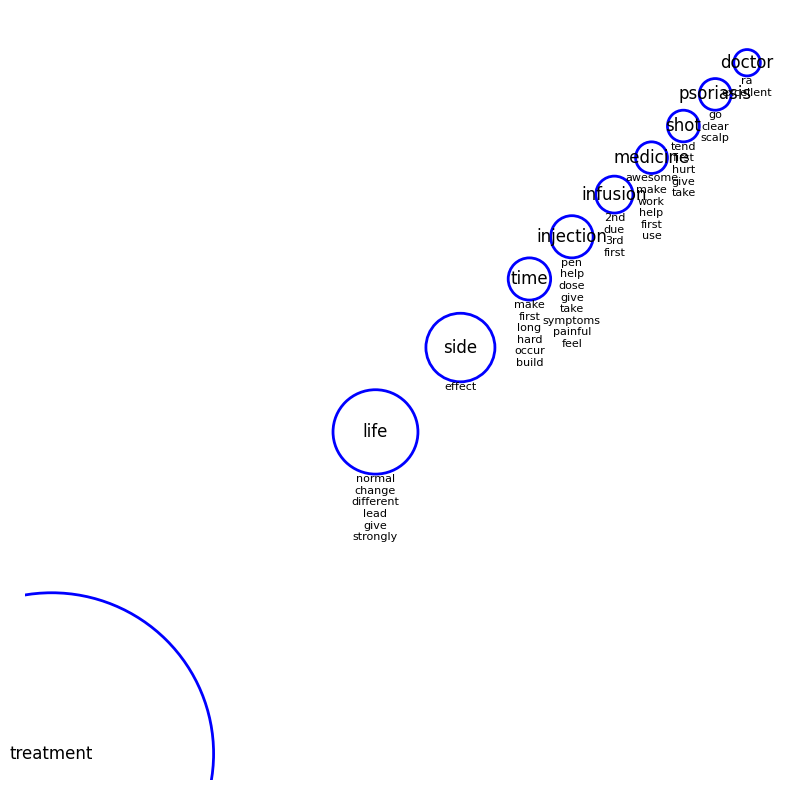

In [118]:
import matplotlib.pyplot as plt

# Récupérer les 10 counts les plus grands
top_10_sentiments = positive_sorted_sentiments[:10]

# Créer une figure
fig, ax = plt.subplots(figsize=(10, 10))

# Définir les tailles de police
large_font = 12
small_font = 8

# Coordonnées initiales des cercles
x = 0
y = 0

# Parcourir les top 10 sentiments
for sentiment, count, mots_associes in top_10_sentiments:
    # Dessiner un cercle avec une taille basée sur le count
    circle = plt.Circle((x, y), count, fill=False, color='b', linewidth=2)
    ax.add_artist(circle)
    
    # Ajouter le texte du sentiment en grand
    ax.annotate(sentiment, (x, y), fontsize=large_font, ha='center', va='center')
    
    # Ajouter les mots associés en petit en dessous
    mots_text = '\n'.join(mots_associes)
    ax.annotate(mots_text, (x, y - count), fontsize=small_font, ha='center', va='top')
    
    # Décaler les coordonnées pour le prochain cercle
    x += 2 * count
    y += 2 * count

# Ajuster les limites de l'axe pour tout afficher
ax.set_xlim(-10, x + 10)
ax.set_ylim(-10, y + 10)

# Masquer les axes
ax.axis('off')

# Afficher la figure
plt.show()
